In [1]:
import os
import git
from pathlib import Path
from typing import List
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import plotly.graph_objects as go
from IPython.display import clear_output
import scipy
import pylustrator

ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = False
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(os.path.join(ROOT_DIR, "results", "combined_results"))
np.random.seed(0)
plots_path = os.path.join(ROOT_DIR, "poster", "plots")


def variance_prior(r, eta, scale=1):
    beta = (eta+1.5)/r
    var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
    return var_prior

def kurtosis_prior(r, eta, fisher=True):
    beta = (eta+1.5)/r
    kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2 
    if fisher:
        return kurtosis - 3
    else:
        return kurtosis 

fixed_palette = {
    'gray': 'xkcd:gray',
    'green': 'xkcd:shamrock green',
    'red': 'xkcd:light red',
    'blue': 'xkcd:blue',
}


def find_master_dfs(root_dir: str) -> List[str]:
    root_path = Path(root_dir)
    if not root_path.exists():
        raise FileNotFoundError(f"Directory not found: {root_dir}")

    master_df_paths = []
    for current_dir, _, files in os.walk(root_path):
        if 'master_df.csv' in files:
            master_df_path = Path(os.path.join(current_dir, 'master_df.csv'))
            master_df_paths.append(str(master_df_path.absolute()))
    return master_df_paths

relevant_cols = ['group', 'obs_var', 'var_lower', 'var_upper', 'obs_kurt', 'kurt_lower',
       'kurt_upper', 'total_samples', 'initial_r', 'initial_eta', # 'initial_scale',
       'kstest_stat_initial', 'kstest_stat_cutoff_0.05',
       'best_r', 'best_eta', # 'best_scale', 
       'kstest_stat_best', # 'n_pval_0.05',
        'param_gaussian',
       'kstest_stat_gaussian', 'kstest_pval_gaussian', 'param_laplace',
       'kstest_stat_laplace', 'kstest_pval_laplace', 'param_t',
       'kstest_stat_t', 'kstest_pval_t', 'kstest_pval_gengamma', 
       'dataset', 'subset', 'transform', 'orientation', 'channel', 'github_plot']

all_paths = find_master_dfs(os.path.join(ROOT_DIR, "results", "case-studies"))
all_master_dfs = []
github_plots_path = "https://github.com/yashdave003/hierarchical-bayesian-model-validation/blob/main/results/case-studies/"

# https://github.com/yashdave003/hierarchical-bayesian-model-validation/blob/main/results/case-studies
# /coco/indoor/wavelet/horizontal/blue/plots/compare_cdf_pdf_layer_2.jpg

for path in all_paths:
    if 'scaleTesting' in path:
        continue
    master_df = pd.read_csv(path)
    master_df = master_df.rename(columns={master_df.columns[0]: 'group'})

    parts = Path(path).parts[-7:]
    GROUP = 'layer'
    if parts[0] == 'case-studies':
        parts = parts[1:]
    if "MRI" in path:
        dataset, slice, transform, orientation, _, _ = parts
        master_df['dataset'] = dataset
        master_df['transform'] = transform
        master_df['subset'] = slice
        master_df['channel'] = np.nan
        master_df['orientation'] = orientation
        master_df['github_plot'] = [github_plots_path+'/'.join([dataset, slice, transform, orientation, 'plots', f'compare_cdf_pdf_{GROUP}_{group}.jpg']) for group in master_df['group']]
    
    elif len(parts) > 6:
        dataset, subset, transform, orientation, channel, _, _ = parts
        master_df['dataset'] = dataset
        master_df['transform'] = transform
        master_df['subset'] = subset
        master_df['channel'] = channel
        master_df['orientation'] = orientation
        master_df['github_plot'] = [github_plots_path+'/'.join([dataset, subset, transform, orientation, channel, 'plots', f'compare_cdf_pdf_{GROUP}_{group}.jpg']) for group in master_df['group']]
    else:
        dataset, size, transform, channel, _, _ = parts
        master_df['dataset'] = dataset
        master_df['transform'] = transform
        master_df['subset'] = size
        master_df['channel'] = channel
        master_df['orientation'] = np.nan
        master_df['github_plot'] = [github_plots_path+'/'.join([dataset, size, transform, channel, 'plots', f'compare_cdf_pdf_{GROUP}_{group}.jpg']) for group in master_df['group']]
    

    all_master_dfs.append(master_df[relevant_cols])
    
main_df = pd.concat(all_master_dfs)
# main_df['prior_var'] = main_df.apply(lambda row : variance_prior(row.loc['best_r'], row.loc['best_eta']), axis = 1)
# main_df['prior_kurt'] = main_df.apply(lambda row : kurtosis_prior(row.loc['best_r'], row.loc['best_eta']), axis = 1)
# main_df['gaussian_kurt'] = np.zeros(main_df.shape[0])
# main_df['laplace_kurt'] = 3*np.ones(main_df.shape[0])
main_df['best_beta'] = (main_df['best_eta'] + 1.5)/main_df['best_r'] 
main_df['total_samples'] = main_df['total_samples']//10 # TODO: look into why total_samples*10
main_df['kstest_stat_cutoff_0.10'] = stats.kstwo(n=main_df['total_samples']).isf(0.1)
kstest_stat_cutoff_2 = 0.2
kstest_stat_cutoff_2_name = 'kstest_stat_cutoff_0.20'
main_df[kstest_stat_cutoff_2_name] = stats.kstwo(n=main_df['total_samples']).isf(kstest_stat_cutoff_2)
main_df['beat_all_priors'] = (main_df['kstest_stat_best'] < np.minimum.reduce([main_df['kstest_stat_gaussian'], main_df['kstest_stat_laplace'], main_df['kstest_stat_t']])).astype(int)

frequency_map = pd.read_csv(os.path.join(ROOT_DIR, "transformed-data", "master-frequency-map.csv")).set_index(['dataset', 'transform', 'group'])
# main_df = main_df.set_index(['dataset', 'subset', 'transform', 'group']).merge(frequency_map, left_index = True, right_index=True).reset_index()
main_df = main_df.set_index(['dataset', 'subset', 'transform', 'group']).reset_index() #[(main_df['dataset'] == 'pastis') | (main_df['dataset'] == 'agriVision') | (main_df['dataset'] == 'spaceNet')]
main_df

c:\Users\yashd\.conda\envs\hbmv_backup2\Lib\site-packages\scipy\stats\_continuous_distns.py:209: RuntimeWarning: divide by zero encountered in divide
  return (0.5/(n if not isinstance(n, Iterable) else np.asanyarray(n)),
c:\Users\yashd\.conda\envs\hbmv_backup2\Lib\site-packages\scipy\stats\_continuous_distns.py:209: RuntimeWarning: divide by zero encountered in divide
  return (0.5/(n if not isinstance(n, Iterable) else np.asanyarray(n)),


,dataset,subset,transform,group,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,...,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma,orientation,channel,github_plot,best_beta,kstest_stat_cutoff_0.10,kstest_stat_cutoff_0.20,beat_all_priors
0,agriVision,full,fourier,2,1292.946700,749.107670,2108.430700,421.841550,123.974430,696.238040,...,0.019029,1.382990e-14,1.808228e-02,NaN,blue,https://github.com/yashdave003/hierarchical-ba...,38.000000,0.018207,0.015955,1
1,agriVision,full,fourier,5,662.654400,382.089750,1248.617800,628.030000,108.212240,1663.239500,...,0.014947,3.910420e-23,7.143833e-03,NaN,blue,https://github.com/yashdave003/hierarchical-ba...,43.333333,0.011300,0.009903,1
2,agriVision,full,fourier,8,256.633900,133.792040,650.845600,1363.730700,99.365600,3639.235800,...,0.012822,2.031100e-27,1.120706e-04,NaN,blue,https://github.com/yashdave003/hierarchical-ba...,53.333333,0.008893,0.007794,1
3,agriVision,full,fourier,11,121.961570,57.215298,390.192930,2698.317600,93.680930,4889.278000,...,0.009905,1.306640e-42,1.278194e-05,NaN,blue,https://github.com/yashdave003/hierarchical-ba...,55.555556,0.005497,0.004818,1
4,agriVision,full,fourier,14,48.468010,23.179575,151.679550,2654.295200,86.305040,4711.629400,...,0.009186,1.510880e-83,3.586150e-06,NaN,blue,https://github.com/yashdave003/hierarchical-ba...,56.666667,0.003633,0.003184,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,syntheticMRI3D,full,wavelet,4,241418.060000,225806.880000,257381.550000,4.450259,4.034465,4.879806,...,0.019904,3.458100e-08,2.871511e-01,ddd,NaN,https://github.com/yashdave003/hierarchical-ba...,1.400000,0.025709,0.022526,1
621,syntheticMRI3D,full,wavelet,5,33947.695000,31871.596000,36147.625000,3.966855,3.001096,5.099455,...,0.011334,1.530190e-33,8.425889e-01,ddd,NaN,https://github.com/yashdave003/hierarchical-ba...,101.000000,0.007099,0.006222,1
622,syntheticMRI3D,full,wavelet,6,6416.669400,5792.756300,7090.980500,13.477583,10.768813,16.435010,...,0.006007,1.010200e-90,4.771315e-54,ddd,NaN,https://github.com/yashdave003/hierarchical-ba...,56.000000,0.002280,0.001998,1
623,syntheticMRI3D,full,wavelet,7,397.892600,357.501070,450.380680,17.566162,9.929181,54.616486,...,0.015012,0.000000e+00,5.369889e-182,ddd,NaN,https://github.com/yashdave003/hierarchical-ba...,37.000000,0.000768,0.000674,1


In [2]:
main_df[['total_samples', 'dataset', 'subset', 'transform', 'orientation', 'channel', 'group', 'kstest_stat_best', 'kstest_stat_cutoff_0.05', 'beat_all_priors', 'github_plot']].to_csv('combined_categories.csv')

In [3]:
fontsize = 20
markersize = 10
labelsize = 20
markertypes = ['x', 'D', 'o', '+']
labels = ['GenGamma', 'Laplace', 'Gaussian', 'Student-t', r'$\alpha\geq0.05$', r'$\alpha\geq0.10$', rf'$\alpha\geq{round_to_sigfigs(kstest_stat_cutoff_2, 2)}$']
points = [Line2D([0], [0], color='k', linestyle='', marker=m, markersize=10) for m in markertypes] + [
    Rectangle((0, 0), 1, 1, color='black', alpha=0.1),
    Rectangle((0, 0), 1, 1, color='black', alpha=0.3),
    Rectangle((0, 0), 1, 1, color='black', alpha=0.5)
]

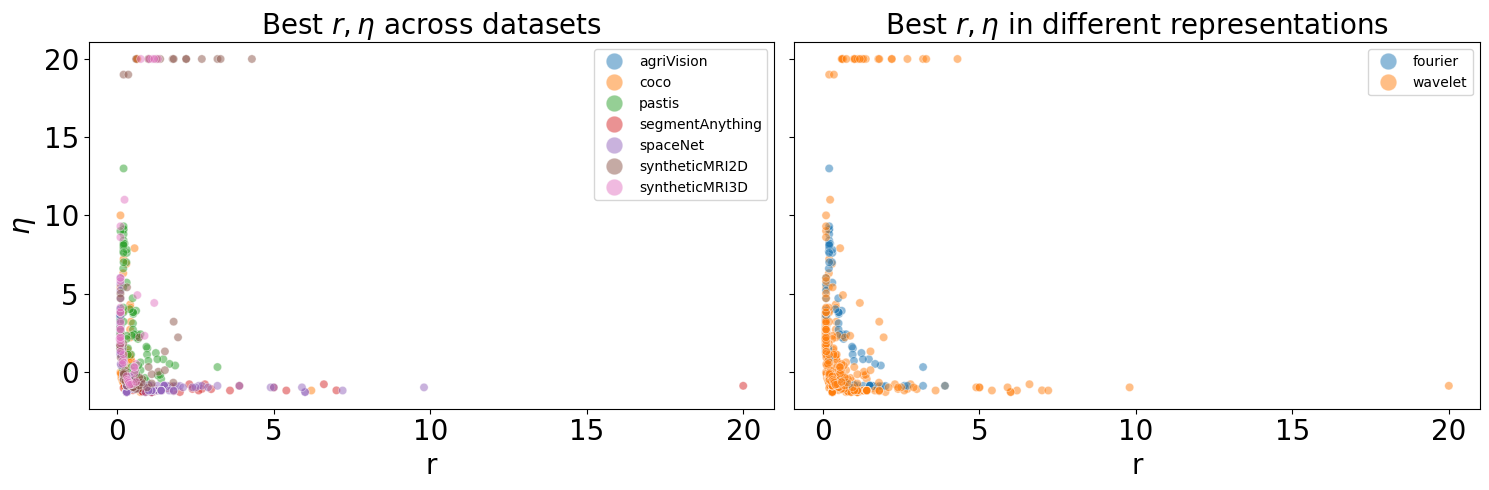

In [4]:
temp = main_df
log_scale = False
r_vals = np.linspace(1, temp['best_r'].max(), 1000)
beta_vals = 3 / (2 * r_vals)

r_vals_2 = np.linspace(0.01, 1, 1000)
beta_vals_2 = 3 / (2 * r_vals_2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='dataset', ax=ax1, alpha=0.5)

ax1.set_title(r'Best $r, \eta$ across datasets', fontsize=20)
ax1.set_ylabel(r'$\eta$', fontsize=20)
ax1.set_xlabel(f"{'Log ' if log_scale else ''}r", fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)
if log_scale:
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    

# Second plot
sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='transform', ax=ax2, alpha=0.5)
ax2.set_title(r'Best $r, \eta$ in different representations', fontsize=20)
ax2.set_ylabel('')
ax2.set_xlabel(f"{'Log ' if log_scale else ''}r", fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
if log_scale:
    ax2.set_xscale('log')
    ax2.set_yscale('log')

ax1.legend(markerscale=2, fontsize=10)
ax2.legend(markerscale=2, fontsize=10)
plt.tight_layout()
plt.show()

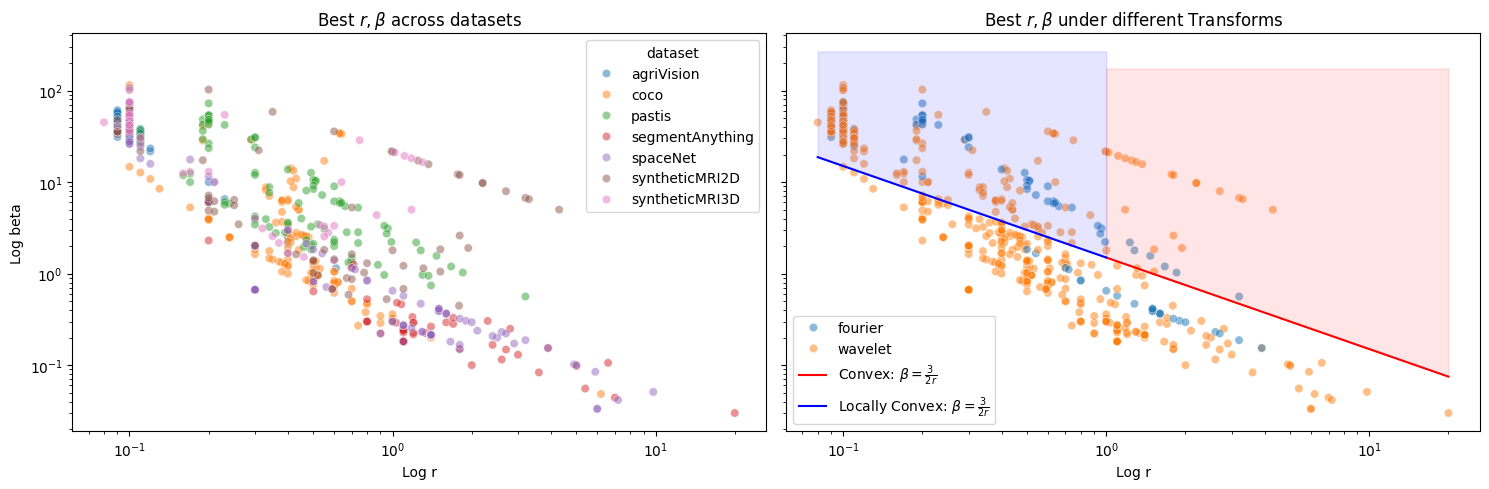

In [6]:
temp = main_df
log_scale = True
r_vals = np.linspace(1, temp['best_r'].max(), 1000)
beta_vals = 3 / (2 * r_vals)

# Create r and beta values for the second line
r_vals_2 = np.linspace(temp['best_r'].min(), 1, 1000)
beta_vals_2 = 3 / (2 * r_vals_2)

# Create figure with shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# First plot
sns.scatterplot(data=temp, x='best_r', y='best_beta', hue='dataset', ax=ax1, alpha=0.5)

ax1.set_title(r'Best $r, \beta$ across datasets')
if log_scale:
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_ylabel('Log beta')
    ax1.set_xlabel('Log r')

# Second plot
sns.scatterplot(data=temp, x='best_r', y='best_beta', hue='transform', ax=ax2, alpha=0.5)
sns.lineplot(x=r_vals, y=beta_vals, label=r'Convex: $\beta = \frac{3}{2r}$', color='red', ax=ax2)
sns.lineplot(x=r_vals_2, y=beta_vals_2, label=r'Locally Convex: $\beta = \frac{3}{2r}$', color='blue', ax=ax2)
# Shade the region above the line
ax2.fill_between(r_vals, beta_vals, y2=ax2.get_ylim()[1], color='red', alpha=0.1)
ax2.fill_between(r_vals_2, beta_vals_2, y2=ax2.get_ylim()[1], color='blue', alpha=0.1)
ax2.set_title(r'Best $r, \beta$ under different Transforms')
if log_scale:
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    # Remove y-label from second plot since it's shared
    ax2.set_ylabel('')
    ax2.set_xlabel('Log r')

plt.tight_layout()
plt.show()


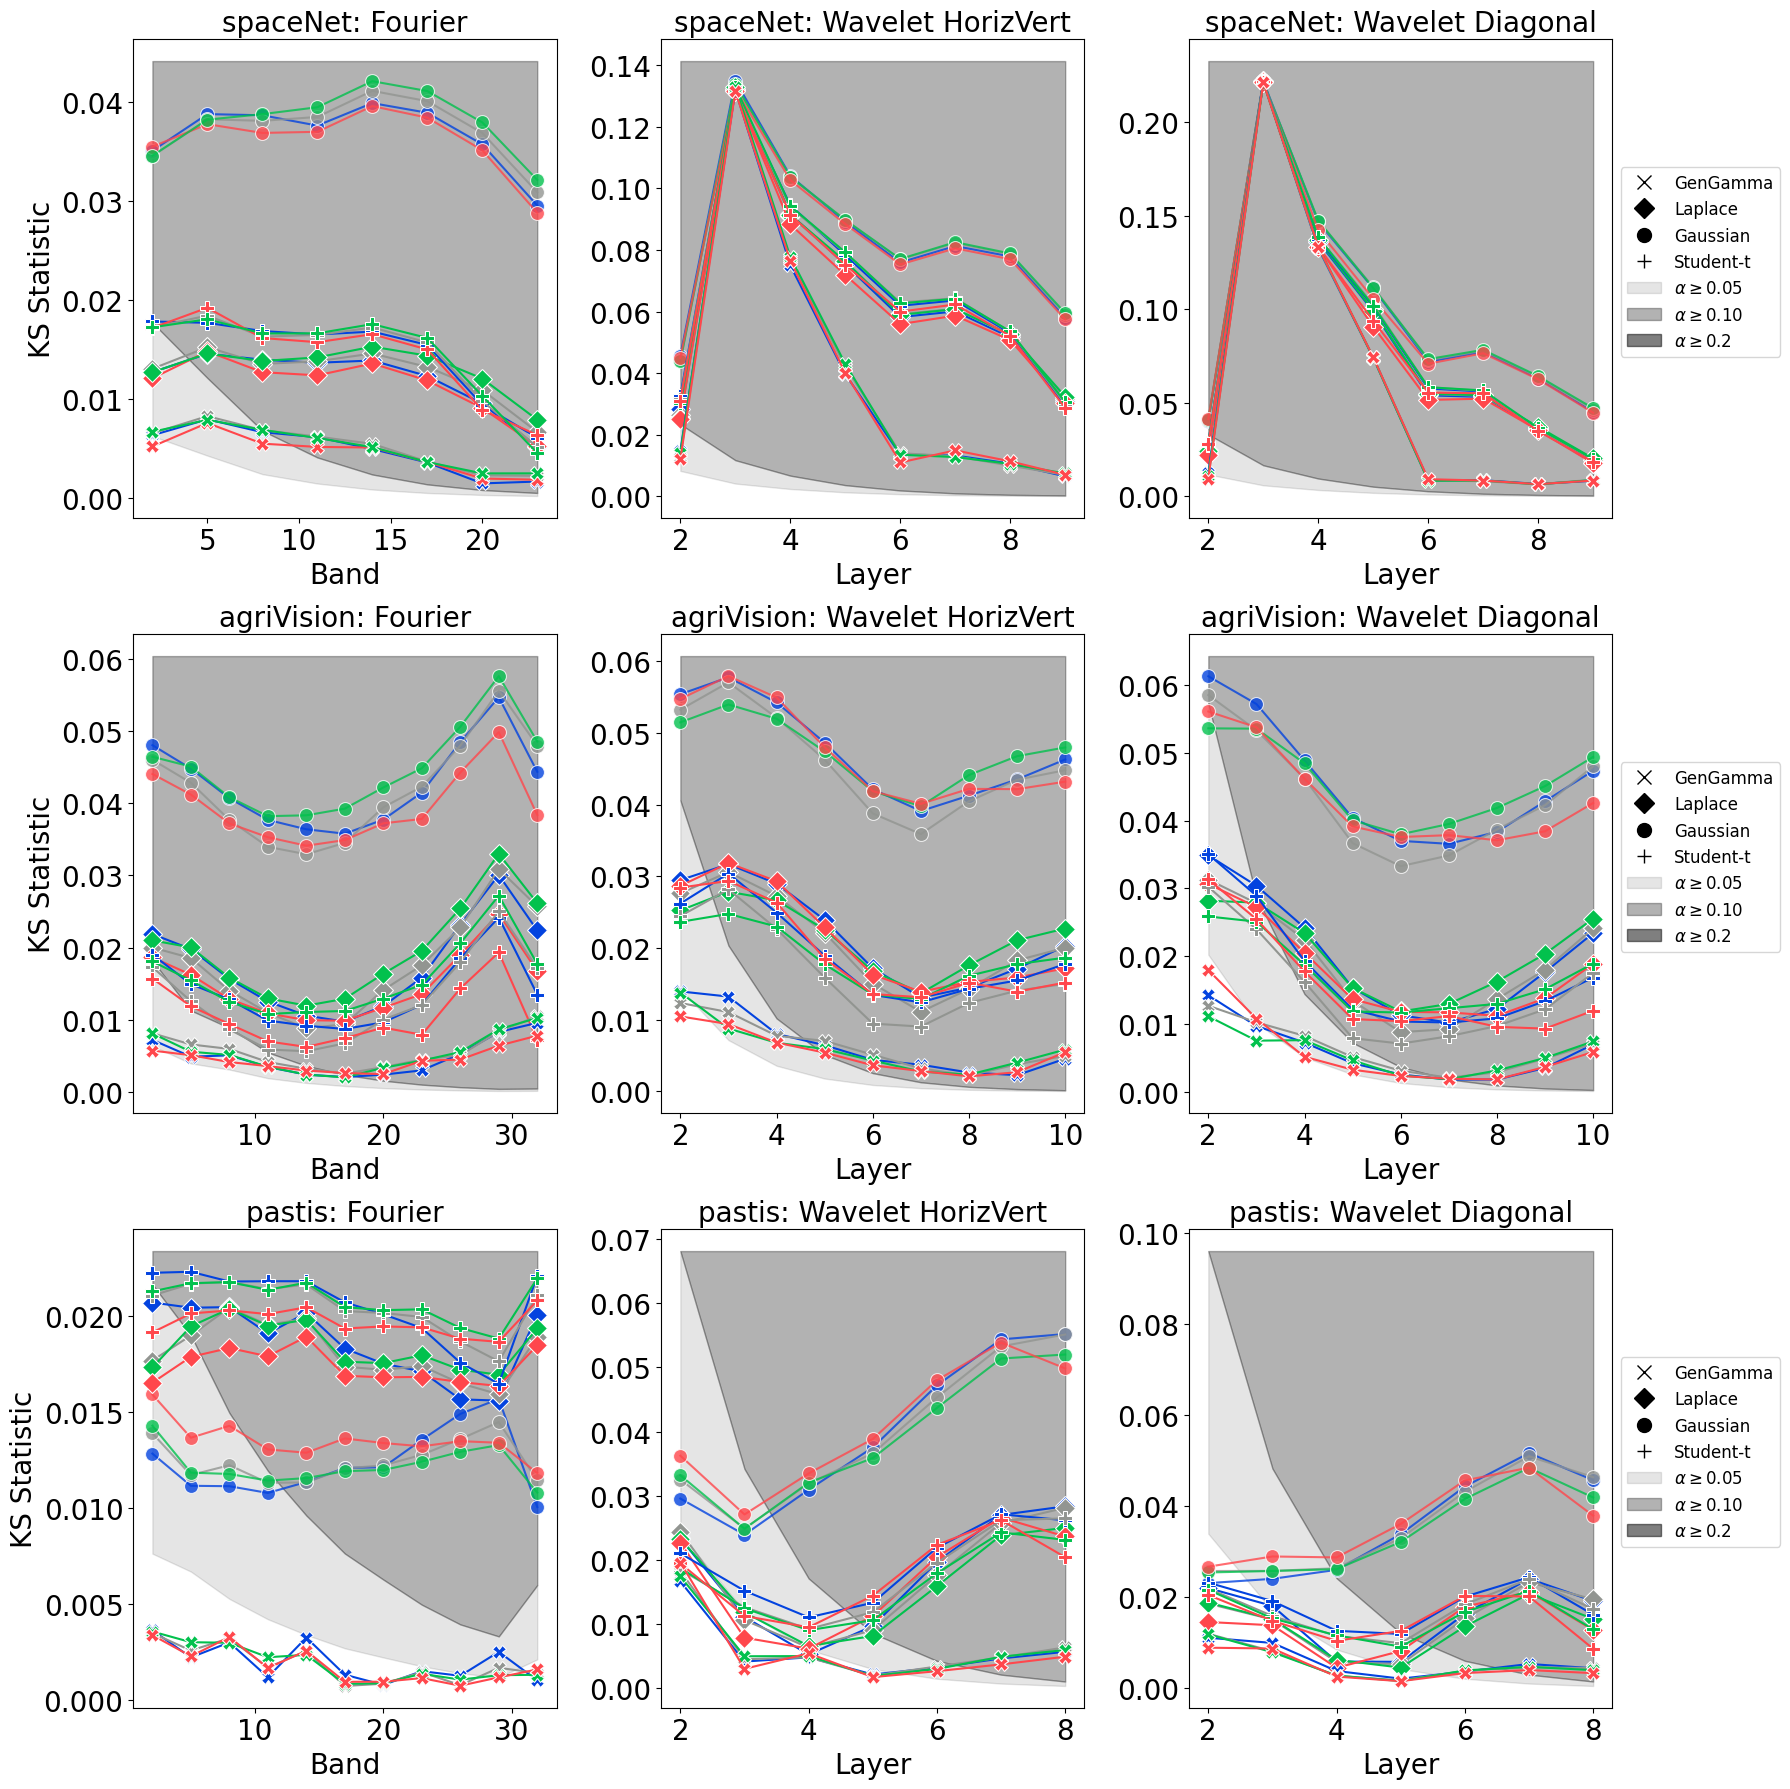

In [ ]:
hue = 'channel'
fixed_palette = {'gray': 'xkcd:gray', 'green': 'xkcd:shamrock green', 'red': 'xkcd:light red', 'blue': 'xkcd:blue'}
marker_size = 10  # Define marker size
toggle_markeredgecolor = True  # Set to True to enable markeredgecolor, False to disable

datasets_to_include = ['spaceNet', 'agriVision', 'pastis']  # List of datasets to include
num_datasets = len(datasets_to_include)

fig, axes = plt.subplots(num_datasets, 3, figsize=(18, 6 * num_datasets))

for i, dataset_name in enumerate(datasets_to_include):
    hue = 'channel'
    fixed_palette = {'gray': 'xkcd:gray', 'green': 'xkcd:shamrock green', 'red': 'xkcd:light red', 'blue': 'xkcd:blue'}

    transform = 'fourier'
    GROUP_NAME = 'Band'
    dataset_filter = (main_df['dataset'] == dataset_name)
    transform_filter = (main_df['transform'] == transform)
    temp = main_df[dataset_filter & transform_filter]
    temp = temp.sort_values('kstest_stat_cutoff_0.05')
    

    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')

    x_lim_0 = axes[i, 0].get_xlim()
    y_lim_0 = axes[i, 0].get_ylim()
    cutoff = temp.groupby('group').agg({'kstest_stat_cutoff_0.05': 'first', 'kstest_stat_cutoff_0.10': 'first'}).reset_index()
    axes[i, 0].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.05'], cutoff['kstest_stat_cutoff_0.10'], color='black', alpha=0.1)
    axes[i, 0].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.10'], max(y_lim_0[1], max(cutoff['kstest_stat_cutoff_0.10'])), color='black', alpha=0.3)
    axes[i, 0].set_xlabel(GROUP_NAME, fontsize=fontsize)
    axes[i, 0].set_ylabel("KS Statistic", fontsize=fontsize)
    axes[i, 0].legend(points, labels, fontsize=12).set_visible(False)
    axes[i, 0].set_title(f"{dataset_name}: Fourier", fontsize=fontsize)
    axes[i, 0].tick_params(axis='both', which='major', labelsize=fontsize)

    transform = 'wavelet'
    GROUP_NAME = 'Layer'
    transform_filter = (main_df['transform'] == transform) & (main_df['orientation'] == 'horizVert')
    temp = main_df[dataset_filter & transform_filter]

    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')

    x_lim_1 = axes[i, 1].get_xlim()
    y_lim_1 = axes[i, 1].get_ylim()
    cutoff = temp.groupby('group').agg({'kstest_stat_cutoff_0.05': 'first', 'kstest_stat_cutoff_0.10': 'first'}).reset_index()
    axes[i, 1].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.05'], cutoff['kstest_stat_cutoff_0.10'], color='black', alpha=0.1)
    axes[i, 1].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.10'], max(y_lim_1[1], max(cutoff['kstest_stat_cutoff_0.10'])), color='black', alpha=0.3)
    axes[i, 1].legend(points, labels, fontsize=12).set_visible(False)
    axes[i, 1].set_xlabel(GROUP_NAME, fontsize=fontsize)
    axes[i, 1].set_ylabel("", fontsize=fontsize)
    axes[i, 1].set_title(f"{dataset_name}: Wavelet HorizVert", fontsize=fontsize)
    axes[i, 1].tick_params(axis='both', which='major', labelsize=fontsize)

    transform = 'wavelet'
    GROUP_NAME = 'Layer'
    transform_filter = (main_df['transform'] == transform) & (main_df['orientation'] == 'diagonal')
    temp = main_df[dataset_filter & transform_filter]

    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')

    x_lim_2 = axes[i, 2].get_xlim()
    y_lim_2 = axes[i, 2].get_ylim()
    cutoff = temp.groupby('group').agg({'kstest_stat_cutoff_0.05': 'first', 'kstest_stat_cutoff_0.10': 'first'}).reset_index()
    axes[i, 2].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.05'], cutoff['kstest_stat_cutoff_0.10'], color='black', alpha=0.1)
    axes[i, 2].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.10'], max(y_lim_2[1], max(cutoff['kstest_stat_cutoff_0.10'])), color='black', alpha=0.3)

    axes[i, 2].set_xlabel(GROUP_NAME, fontsize=fontsize)
    axes[i, 2].set_ylabel("", fontsize=fontsize)
    axes[i, 2].legend(points, labels, fontsize=12, bbox_to_anchor=(1, 0.75))
    axes[i, 2].set_title(f"{dataset_name}: Wavelet Diagonal", fontsize=fontsize)
    axes[i, 2].tick_params(axis='both', which='major', labelsize=fontsize)

plt.tight_layout()
plt.show()


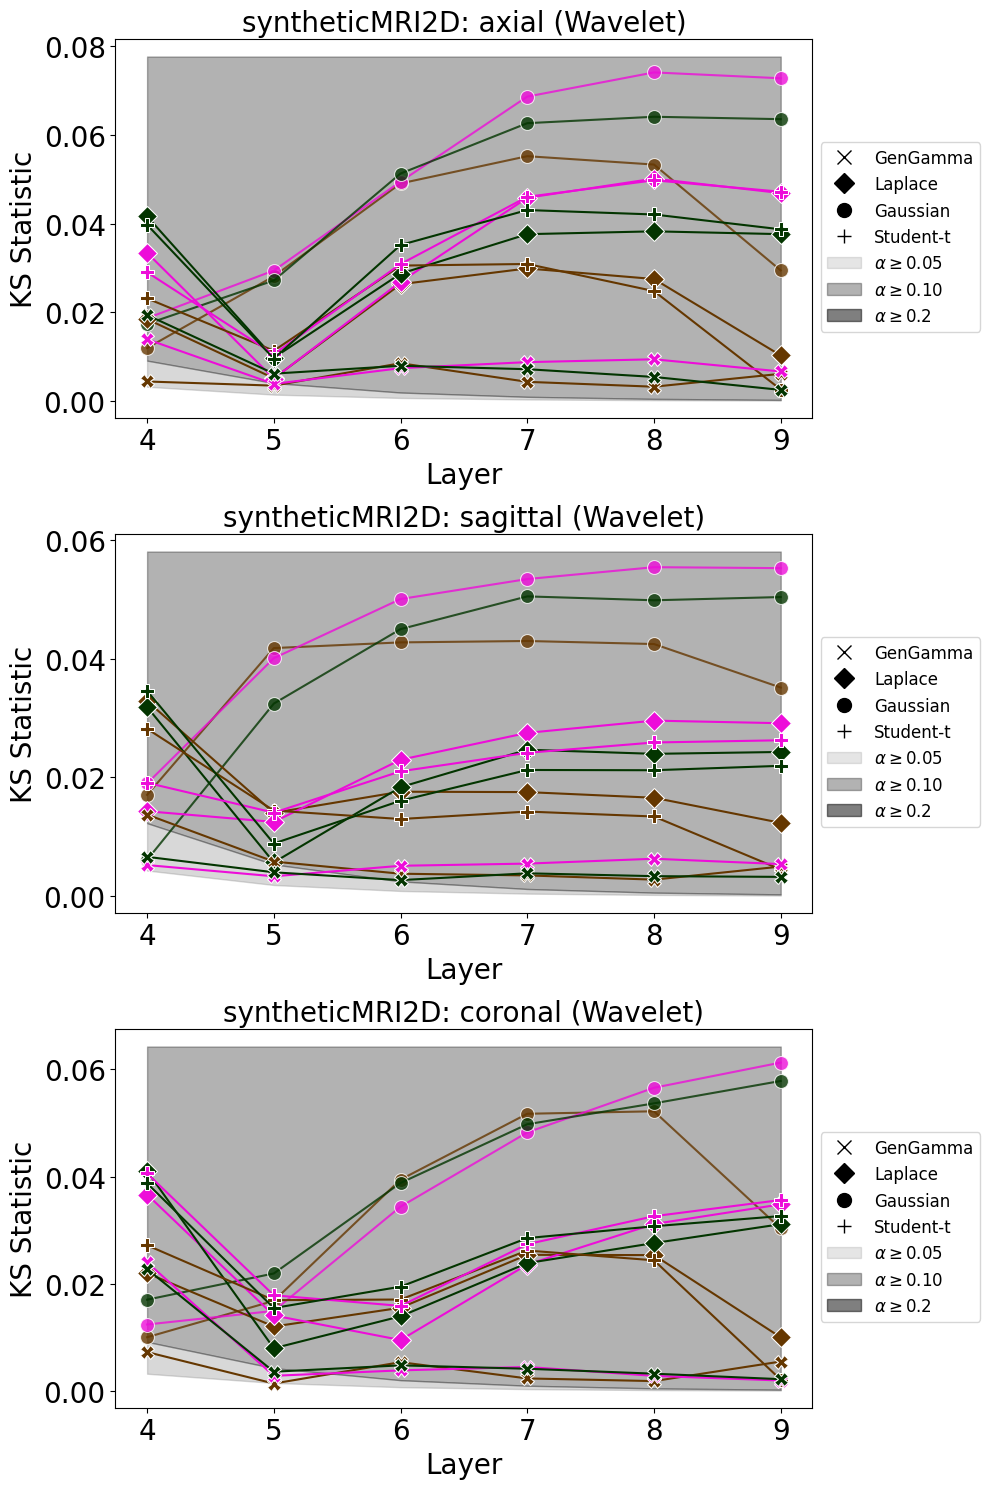

In [40]:
hue = 'channel'
fixed_palette = {'gray': 'xkcd:gray', 'green': 'xkcd:shamrock green', 'red': 'xkcd:light red', 'blue': 'xkcd:blue', 'horizontal': 'xkcd:fuchsia', 'vertical': 'xkcd:dark green', 'diagonal': 'xkcd:brown'}
marker_size = 10  # Define marker size

datasets_to_include = ['syntheticMRI2D']  # List of datasets to include
dataset_name = datasets_to_include[0]
num_datasets = len(datasets_to_include)
subsets_to_include = ['axial', 'sagittal', 'coronal']  # List of subsets to include
num_subsets = len(subsets_to_include)
fig, axes = plt.subplots(num_subsets, 1, figsize=(10, 5 * num_subsets))

if num_subsets == 1:
    axes = [axes]

for j, subset_name in enumerate(subsets_to_include):
    hue = 'orientation'
    transform = 'wavelet'
    GROUP_NAME = 'Layer'
    dataset_filter = (main_df['dataset'] == dataset_name)
    subset_filter = (main_df['subset'] == subset_name)
    transform_filter = (main_df['transform'] == transform) & (main_df['group'] > 3)
    temp = main_df[dataset_filter & subset_filter & transform_filter]

    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[j], markersize=marker_size)
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[j], markersize=marker_size)
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[j], markersize=marker_size)
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[j], markersize=marker_size)

    x_lim = axes[j].get_xlim()
    y_lim = axes[j].get_ylim()
    cutoff = temp.groupby('group').agg({'kstest_stat_cutoff_0.05': 'first', 'kstest_stat_cutoff_0.10': 'first'}).reset_index()
    axes[j].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.05'], cutoff['kstest_stat_cutoff_0.10'], color='gray', alpha=0.3)
    axes[j].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.10'], max(y_lim[1], max(cutoff['kstest_stat_cutoff_0.10'])), color='black', alpha=0.3)

    axes[j].set_xlabel(GROUP_NAME, fontsize=fontsize)
    axes[j].set_ylabel("KS Statistic", fontsize=fontsize)
    axes[j].legend(points, labels, fontsize=12, bbox_to_anchor=(1, 0.75))
    axes[j].set_title(f"{dataset_name}: {subset_name} (Wavelet)", fontsize=fontsize)
    axes[j].tick_params(axis='both', which='major', labelsize=fontsize)

plt.tight_layout()
plt.show()


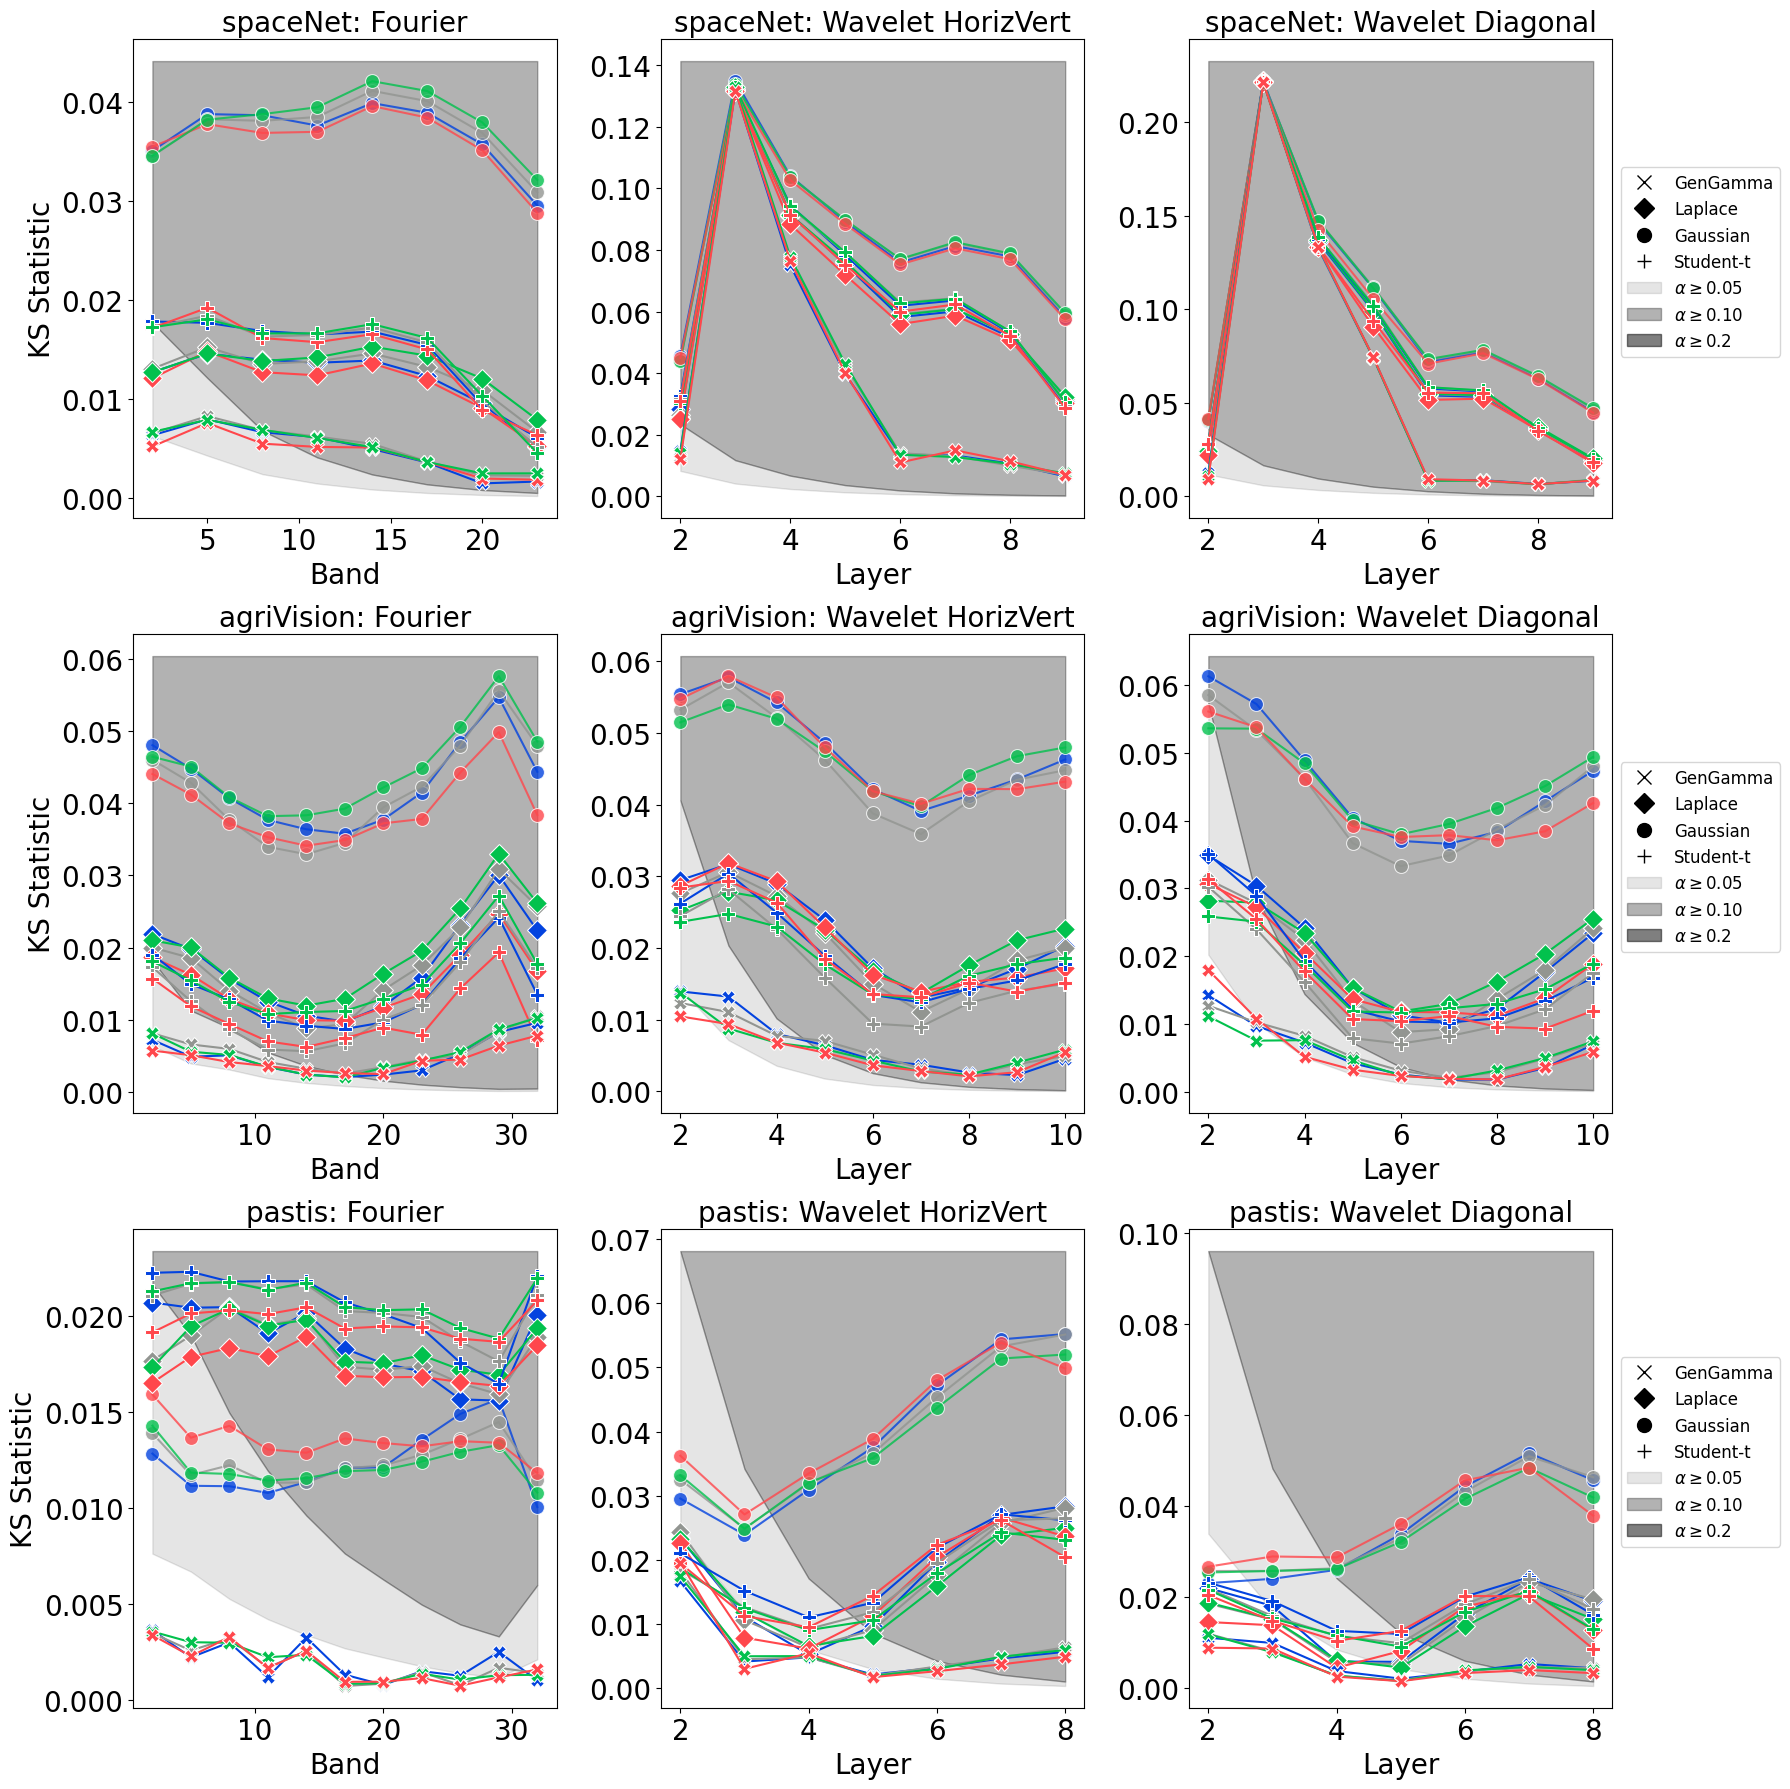

In [10]:
hue = 'channel'
fixed_palette = {'gray': 'xkcd:gray', 'green': 'xkcd:shamrock green', 'red': 'xkcd:light red', 'blue': 'xkcd:blue'}
marker_size = 10  # Define marker size
toggle_markeredgecolor = True  # Set to True to enable markeredgecolor, False to disable

datasets_to_include = ['spaceNet', 'agriVision', 'pastis']  # List of datasets to include
num_datasets = len(datasets_to_include)

fig, axes = plt.subplots(num_datasets, 3, figsize=(18, 6 * num_datasets))

for i, dataset_name in enumerate(datasets_to_include):
    hue = 'channel'
    fixed_palette = {'gray': 'xkcd:gray', 'green': 'xkcd:shamrock green', 'red': 'xkcd:light red', 'blue': 'xkcd:blue'}

    transform = 'fourier'
    GROUP_NAME = 'Band'
    dataset_filter = (main_df['dataset'] == dataset_name)
    transform_filter = (main_df['transform'] == transform)
    temp = main_df[dataset_filter & transform_filter]
    temp = temp.sort_values('kstest_stat_cutoff_0.05')
    

    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')

    x_lim_0 = axes[i, 0].get_xlim()
    y_lim_0 = axes[i, 0].get_ylim()
    cutoff = temp.groupby('group').agg({'kstest_stat_cutoff_0.05': 'first', 'kstest_stat_cutoff_0.10': 'first'}).reset_index()
    axes[i, 0].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.05'], cutoff['kstest_stat_cutoff_0.10'], color='black', alpha=0.1)
    axes[i, 0].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.10'], max(y_lim_0[1], max(cutoff['kstest_stat_cutoff_0.10'])), color='black', alpha=0.3)
    axes[i, 0].set_xlabel(GROUP_NAME, fontsize=fontsize)
    axes[i, 0].set_ylabel("KS Statistic", fontsize=fontsize)
    axes[i, 0].legend(points, labels, fontsize=12).set_visible(False)
    axes[i, 0].set_title(f"{dataset_name}: Fourier", fontsize=fontsize)
    axes[i, 0].tick_params(axis='both', which='major', labelsize=fontsize)

    transform = 'wavelet'
    GROUP_NAME = 'Layer'
    transform_filter = (main_df['transform'] == transform) & (main_df['orientation'] == 'horizVert')
    temp = main_df[dataset_filter & transform_filter]

    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')

    x_lim_1 = axes[i, 1].get_xlim()
    y_lim_1 = axes[i, 1].get_ylim()
    cutoff = temp.groupby('group').agg({'kstest_stat_cutoff_0.05': 'first', 'kstest_stat_cutoff_0.10': 'first'}).reset_index()
    axes[i, 1].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.05'], cutoff['kstest_stat_cutoff_0.10'], color='black', alpha=0.1)
    axes[i, 1].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.10'], max(y_lim_1[1], max(cutoff['kstest_stat_cutoff_0.10'])), color='black', alpha=0.3)
    axes[i, 1].legend(points, labels, fontsize=12).set_visible(False)
    axes[i, 1].set_xlabel(GROUP_NAME, fontsize=fontsize)
    axes[i, 1].set_ylabel("", fontsize=fontsize)
    axes[i, 1].set_title(f"{dataset_name}: Wavelet HorizVert", fontsize=fontsize)
    axes[i, 1].tick_params(axis='both', which='major', labelsize=fontsize)

    transform = 'wavelet'
    GROUP_NAME = 'Layer'
    transform_filter = (main_df['transform'] == transform) & (main_df['orientation'] == 'diagonal')
    temp = main_df[dataset_filter & transform_filter]

    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')

    x_lim_2 = axes[i, 2].get_xlim()
    y_lim_2 = axes[i, 2].get_ylim()
    cutoff = temp.groupby('group').agg({'kstest_stat_cutoff_0.05': 'first', 'kstest_stat_cutoff_0.10': 'first'}).reset_index()
    axes[i, 2].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.05'], cutoff['kstest_stat_cutoff_0.10'], color='black', alpha=0.1)
    axes[i, 2].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.10'], max(y_lim_2[1], max(cutoff['kstest_stat_cutoff_0.10'])), color='black', alpha=0.3)

    axes[i, 2].set_xlabel(GROUP_NAME, fontsize=fontsize)
    axes[i, 2].set_ylabel("", fontsize=fontsize)
    axes[i, 2].legend(points, labels, fontsize=12, bbox_to_anchor=(1, 0.75))
    axes[i, 2].set_title(f"{dataset_name}: Wavelet Diagonal", fontsize=fontsize)
    axes[i, 2].tick_params(axis='both', which='major', labelsize=fontsize)

plt.tight_layout()
plt.show()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

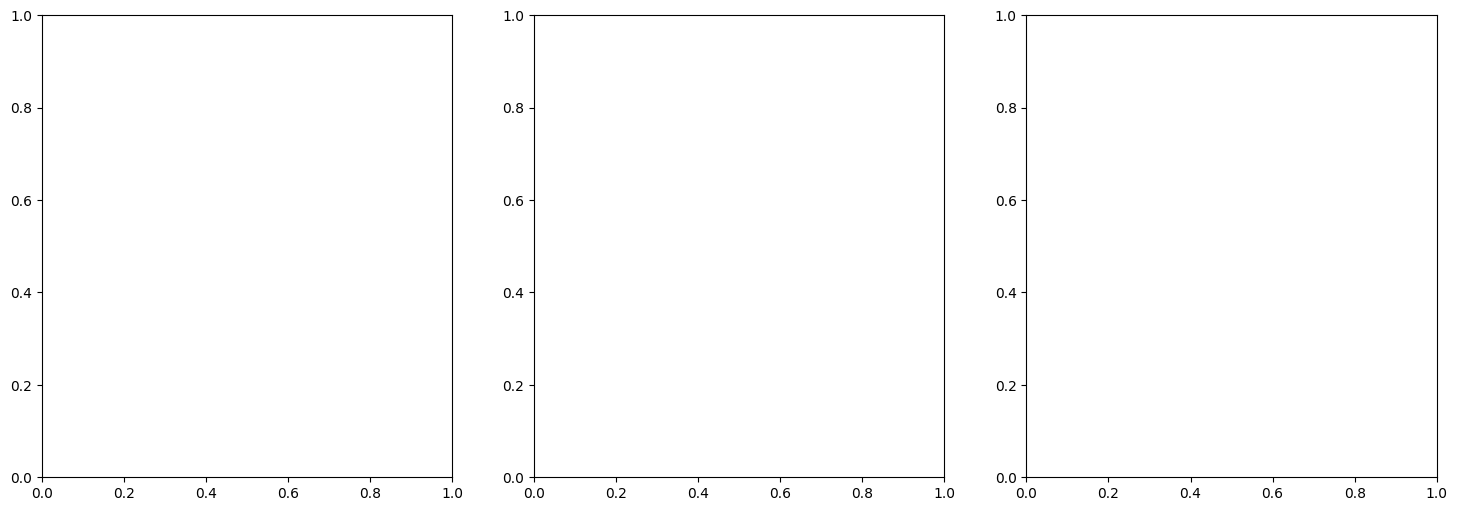

In [ ]:
datasets_to_include = ['syntheticMRI3D-full-']  # List of datasets to include
orientations = ['aad', 'ada', 'add', 'daa', 'dad', 'dda', 'ddd']
num_datasets = len(datasets_to_include)

fig, axes = plt.subplots(num_datasets, 3, figsize=(18, 6 * num_datasets))

for i, data_name in enumerate(datasets_to_include):
    hue = 'channel'
    fixed_palette = {'gray': 'xkcd:gray', 'green': 'xkcd:shamrock green', 'red': 'xkcd:light red', 'blue': 'xkcd:blue'}

    for j, orientation in enumerate(['aad', 'ada', 'add', 'daa', 'dad', 'dda']):

        transform = 'wavelet-aad'
        GROUP_NAME = 'layer'
        dataset_name, subset_name = data_name.split("-")
        transform, orientation = transform.split("-")

        dataset_filter = (main_df['dataset'] == dataset_name) & (main_df['subset'] == subset_name) 
        transform_filter = (main_df['transform'] == transform) & (main_df['orientation'] == orientation) 
        temp = main_df[dataset_filter & transform_filter]
        temp = temp.sort_values('kstest_stat_cutoff_0.05')

        sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[i, j], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
        sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[i, j], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
        sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[i, j], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
        sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[i, j], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')

        x_lim = axes[i, j].get_xlim()
        y_lim = axes[i, j].get_ylim()
        cutoff = temp.groupby('group').agg({'kstest_stat_cutoff_0.05': 'first', 'kstest_stat_cutoff_0.10': 'first'}).reset_index()
        axes[i, j].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.05'], cutoff['kstest_stat_cutoff_0.10'], color='black', alpha=0.1)
        axes[i, j].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.10'], max(y_lim[1], max(cutoff['kstest_stat_cutoff_0.10'])), color='black', alpha=0.3)
        axes[i, j].set_xlabel(GROUP_NAME, fontsize=fontsize)
        axes[i, j].set_ylabel("KS Statistic", fontsize=fontsize)
        axes[i, j].legend(points, labels, fontsize=12).set_visible(False)
        axes[i, j].set_title(f"{dataset_name} {subset_name}: Wavelet {orientation}", fontsize=fontsize)
        axes[i, j].tick_params(axis='both', which='major', labelsize=fontsize)

    transform = 'wavelet-ddd'
    GROUP_NAME = 'layer'
    dataset_name, subset_name = data_name.split("-")
    transform, orientation = transform.split("-")

    dataset_filter = (main_df['dataset'] == dataset_name) & (main_df['subset'] == subset_name) 
    transform_filter = (main_df['transform'] == transform) & (main_df['orientation'] == orientation) 
    temp = main_df[dataset_filter & transform_filter]
    temp = temp.sort_values('kstest_stat_cutoff_0.05')

    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')

    x_lim_1 = axes[i, 7].get_xlim()
    y_lim_1 = axes[i, 7].get_ylim()
    cutoff = temp.groupby('group').agg({'kstest_stat_cutoff_0.05': 'first', 'kstest_stat_cutoff_0.10': 'first'}).reset_index()
    axes[i, 7].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.05'], cutoff['kstest_stat_cutoff_0.10'], color='black', alpha=0.1)
    axes[i, 7].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.10'], max(y_lim_1[1], max(cutoff['kstest_stat_cutoff_0.10'])), color='black', alpha=0.3)
    axes[i, 7].legend(points, labels, fontsize=12).set_visible(False)
    axes[i, 7].set_xlabel(GROUP_NAME, fontsize=fontsize)
    axes[i, 7].set_ylabel("", fontsize=fontsize)
    axes[i, 7].set_title(f"{dataset_name} {subset_name}: Wavelet {orientation}", fontsize=fontsize)
    axes[i, 7].tick_params(axis='both', which='major', labelsize=fontsize)

    
plt.tight_layout()
plt.show()


C:\Users\yashd\AppData\Local\Temp\ipykernel_29360\529323448.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[j], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
C:\Users\yashd\AppData\Local\Temp\ipykernel_29360\529323448.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[j], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
C:\Users\yashd\AppData\Local\Temp\ipykernel_29360\529323448.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[j], markersize=marker_size, marker

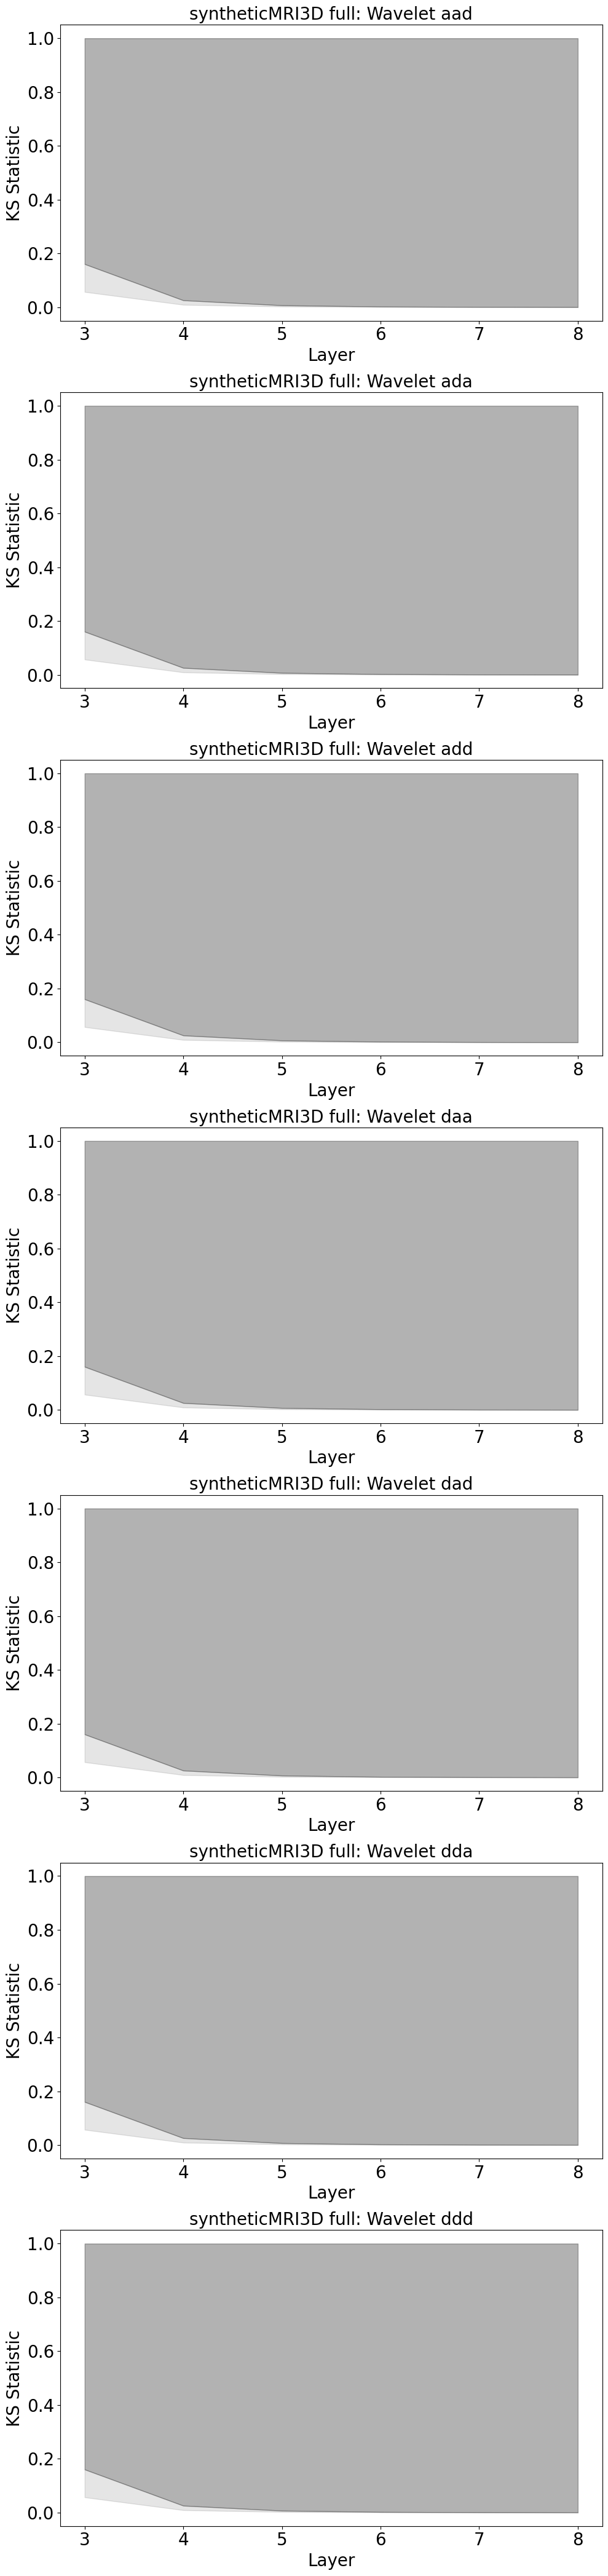

In [ ]:
datasets_to_include = ['syntheticMRI3D-full']  # List of datasets to include
orientations = ['aad', 'ada', 'add', 'daa', 'dad', 'dda', 'ddd']
num_datasets = len(datasets_to_include)
fixed_palette = {'gray': 'xkcd:gray', 'green': 'xkcd:shamrock green', 'red': 'xkcd:light red', 'blue': 'xkcd:blue'}

fig, axes = plt.subplots(len(orientations), 1, figsize=(10, 6 * len(orientations)))

if len(orientations) == 1:
    axes = [axes]  # Ensure axes is iterable when there's only one orientation

for i, data_name in enumerate(datasets_to_include):
    hue = 'channel'
    

    dataset_name, subset_name = data_name.split("-")

    for j, orientation in enumerate(orientations):
        transform = 'wavelet'
        GROUP_NAME = 'Layer'

        dataset_filter = (main_df['dataset'] == dataset_name) & (main_df['subset'] == subset_name)
        transform_filter = (main_df['transform'] == transform) & (main_df['orientation'] == orientation)
        temp = main_df[dataset_filter & transform_filter]
        temp = temp.sort_values('kstest_stat_cutoff_0.05')

        sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[j], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
        sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[j], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
        sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[j], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
        sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[j], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')

        x_lim = axes[j].get_xlim()
        y_lim = axes[j].get_ylim()
        cutoff = temp.groupby('group').agg({'kstest_stat_cutoff_0.05': 'first', 'kstest_stat_cutoff_0.10': 'first'}).reset_index()
        axes[j].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.05'], cutoff['kstest_stat_cutoff_0.10'], color='black', alpha=0.1)
        axes[j].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.10'], max(y_lim[1], max(cutoff['kstest_stat_cutoff_0.10'])), color='black', alpha=0.3)
        axes[j].set_xlabel(GROUP_NAME, fontsize=fontsize)
        axes[j].set_ylabel("KS Statistic", fontsize=fontsize)
        axes[j].legend(points, labels, fontsize=12).set_visible(False)
        axes[j].set_title(f"{dataset_name} {subset_name}: Wavelet {orientation}", fontsize=fontsize)
        axes[j].tick_params(axis='both', which='major', labelsize=fontsize)

plt.tight_layout()
plt.show()


C:\Users\yashd\AppData\Local\Temp\ipykernel_29360\1912383720.py:31: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
C:\Users\yashd\AppData\Local\Temp\ipykernel_29360\1912383720.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i][j].legend(title="Channel", fontsize=fontsize - 2).set_visible("False")
C:\Users\yashd\AppData\Local\Temp\ipykernel_29360\1912383720.py:31: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
C:\Users\yashd\AppData\Local\Temp\ipykernel_29360\1912383720.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i][j].legend(title="Channel", fontsize=fontsize - 2).set_visible("False")


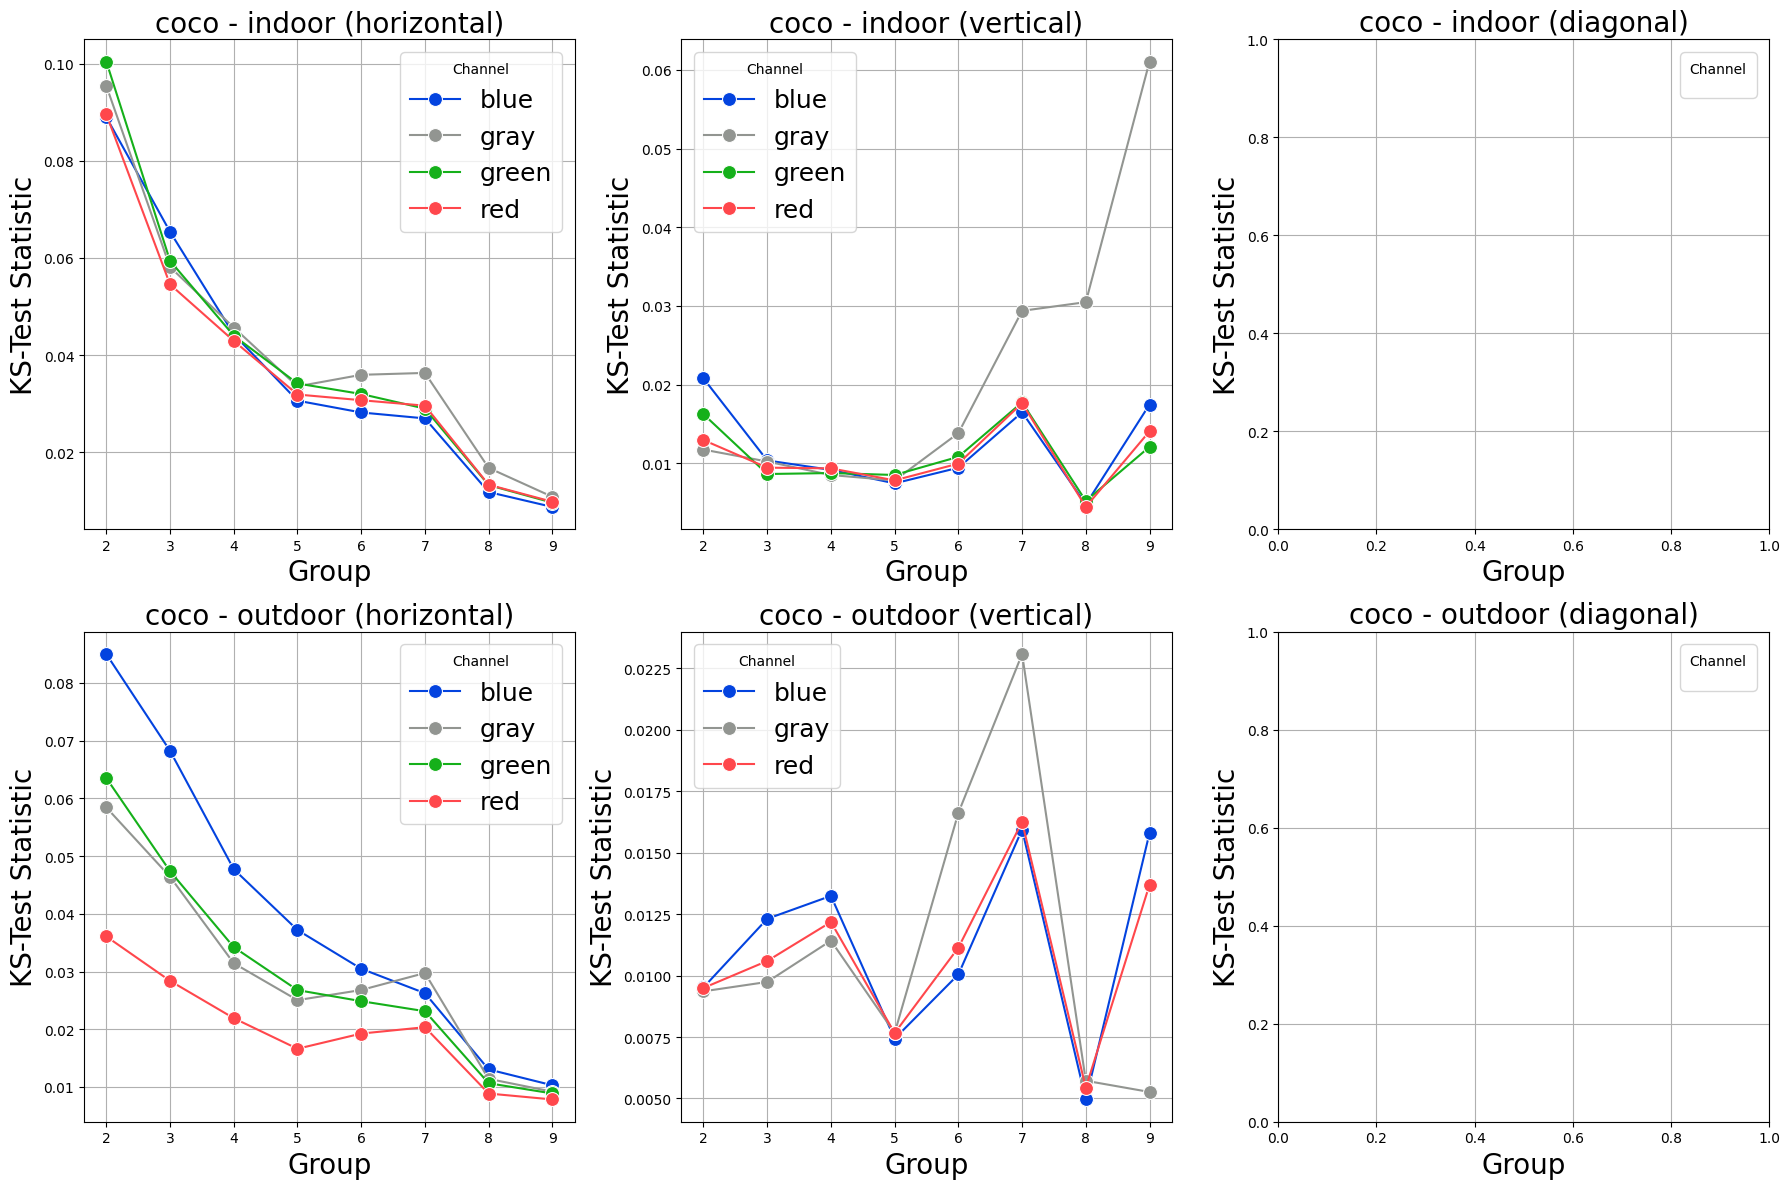

In [30]:
# Define parameters
dataset_name = 'coco'
subsets_to_include = ['indoor', 'outdoor']
orientations = ['horizontal', 'vertical', 'diagonal']
channels = ['red', 'blue', 'green', 'gray']
fixed_palette = {'horizontal': 'xkcd:light red', 'vertical': 'xkcd:blue', 'diagonal': 'xkcd:green'}
channel_palette = {'red': 'xkcd:light red', 'blue': 'xkcd:blue', 'green': 'xkcd:green', 'gray': 'xkcd:gray'}
marker_size = 10


# Number of subsets and orientations
num_subsets = len(subsets_to_include)
num_orientations = len(orientations)

# Create figure
fig, axes = plt.subplots(num_subsets, num_orientations, figsize=(6 * num_orientations, 6 * num_subsets))

# Ensure axes is always a 2D array for consistency
if num_subsets == 1:
    axes = [axes]
if num_orientations == 1:
    axes = [[ax] for ax in axes]

# Loop through subsets and orientations
for i, subset_name in enumerate(subsets_to_include):
    for j, orientation in enumerate(orientations):
        # Filter data for the current subset and orientation
        subset_filter = (main_df['dataset'] == dataset_name) & (main_df['subset'] == subset_name) & (main_df['orientation'] == orientation)
        temp = main_df[subset_filter]

        sns.lineplot(
                data=temp,
                x='group',
                y='kstest_stat_best',
                ax=axes[i][j],
                marker='o',
                markersize=marker_size,
                hue='channel',
                palette=channel_palette)
        
        # Customize plot
        axes[i][j].set_title(f"{dataset_name} - {subset_name} ({orientation})", fontsize=fontsize)
        axes[i][j].set_xlabel("Group", fontsize=fontsize)
        axes[i][j].set_ylabel("KS-Test Statistic", fontsize=fontsize)
        axes[i][j].legend(title="Channel", fontsize=fontsize - 2).set_visible("False")
        axes[i][j].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()